In [173]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
from scipy.ndimage.measurements import label
from project_functions import *
# Read trained model by the Linear SVM
dist_pickle = pickle.load( open( "svc_model_best.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
color_space = dist_pickle["color_space"] 
orient = dist_pickle["orient"] # HOG orientations
pix_per_cell = dist_pickle["pix_per_cell"] # HOG pixels per cell
cell_per_block = dist_pickle["cell_per_block"] # HOG cells per block
spatial_size = dist_pickle["spatial_size"] # Spatial binning dimensions
hist_bins = dist_pickle["hist_bins"] # Number of histogram bins

In [174]:
import math
import collections
# Create deque data structure to store heatmaps
heatmaps = collections.deque(maxlen=5)
heatmaps2 = collections.deque(maxlen=3)
heatmaps3 = collections.deque(maxlen=5)
heatmaps.clear()
heatmaps2.clear()
heatmaps3.clear()


def Image_Process(image):
    
    background = np.zeros_like(image[:,:,0]).astype(np.float)
    
    boxes = []
    boxes = find_cars1(image, ystart=400, ystop=656, xstart=950, xstop=1280, scale=2.0, step=2, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=400, ystop=500, xstart=950, xstop=1280, scale=1.5, step=2, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=400, ystop=656, xstart=0, xstop=330, scale=1.5, step=2, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=400, ystop=500, xstart=0, xstop=330, scale=1.5, step=2, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=400, ystop=480, xstart=330, xstop=1200, scale=0.75, step=1, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=450, ystop=540, xstart=800, xstop=900, scale=1, step=1, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=400, ystop=656, xstart=900, xstop=1280, scale=1.5, step=2, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    
    draw_img2 = draw_boxes(image, boxes)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold = 3)
    # Visualize the heatmap when displaying   
    heatmap = np.clip(heat, 0, 255)
    

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img1, bboxes1 = draw_labeled_bboxes(np.copy(image), labels)
 
    # Filtered out the detected box which just appeared only twice in all of the stored previous 3 frames 
    heat2 =  add_heat(background,bboxes1)
    heatmaps2.append(heat2)
    heatmap_sum2 = sum(heatmaps2)
    heatmap_filtered = apply_threshold(heatmap_sum2,threshold = 2)
    
    # Average 5 heatmaps from previous frames
    heatmaps.append(heatmap_filtered)
    heatmap_final = sum(heatmaps)/len(heatmaps)
    heatmap_final = apply_threshold(heatmap_final,threshold = 0.7)
    
    labels2 = label(heatmap_final)
    draw_img3, bboxes2 = draw_labeled_bboxes(np.copy(image), labels2)
    
    # Filtered out suspicious boxes again
    heat3 =  add_heat(background,bboxes2)
    heatmaps3.append(heat3)
    heatmap_sum3 = sum(heatmaps3)
    heatmap_filtered2 = apply_threshold(heatmap_sum3,threshold = 3)
    
    labels3 = label(heatmap_filtered2)
    draw_img4, bboxes3 = draw_labeled_bboxes(np.copy(image), labels3)
    
    return draw_img4, draw_img2, heatmap_sum2



In [175]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
heatmaps.clear()
heatmaps2.clear()
def Frame_Process(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(Image_Process(image)[0], cv2.COLOR_BGR2RGB)


In [176]:
# Test Video
Output2 = 'output_test_video.mp4'
clip2 = VideoFileClip("test_video.mp4")
Clip2 = clip2.fl_image(Frame_Process) #NOTE: this function expects color images!!
Clip2.write_videofile(Output2, audio=False)

[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4


 97%|█████████▋| 38/39 [01:06<00:01,  1.77s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 



In [163]:

# Output Video
Output = 'output_video.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
Clip = clip1.fl_image(Frame_Process) #NOTE: this function expects color images!!

Clip.write_videofile(Output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [41:50<00:01,  1.63s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



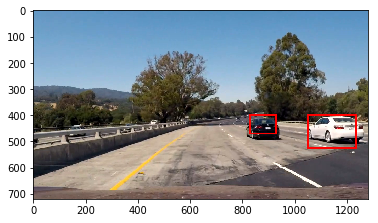

In [172]:
# test_image = clip2.get_frame(1.5)
# test_image1 = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
# plt.imshow(cv2.cvtColor(Image_Process(test_image1)[0], cv2.COLOR_BGR2RGB))
# clip2.save_frame('test_images/frame6.jpg',t=1.5)